# Import libraries

In [200]:
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import emcee
import corner

# Define constants

In [201]:
c = 299792.458 #is this in the correct units?
#H0 = 75 # might be able to find this myself?
f0 = 6.61* 10**-9 * 10**(-7) * (3.2408*10**(-25))**(-2)
megaparsec = 3.0856775814913673 * 10**10

# Some key functions

In [96]:
#order of variables: z, k, H0, omega_M, omega_DE, LPeakLambda, rc

def scale_factor(z):
    return 1/(1+z)

def curv_scale(H0, omega_M, omega_DE):
    R0 = c/(75*np.sqrt(np.abs(omega_M+omega_DE-1)))
    return R0

def Friedmann_eq(z, k, H0, omega_M, omega_DE):
    a = scale_factor(z)
    R0 = curv_scale(H0, omega_M, omega_DE)
    H2 = (75**2)*(omega_M/(a**3) + omega_DE - k*(c**2)/((R0**2)*(a**2)))
    return np.sqrt(np.abs(H2))

def integrand(z, k, H0, omega_M, omega_DE):
    return c/Friedmann_eq(z, k, H0, omega_M, omega_DE)

def co_moving_dist(z_up, k, H0, omega_M, omega_DE):
    dist_c = []
    for zval in z_up:
        dist, err = scp.integrate.quad(integrand, 0, zval, args = (k, H0, omega_M, omega_DE))
    dist_c.append(dist)
    return np.array(dist_c)

def Sk(k, H0, omega_M, omega_DE, rc):
    R0 = curv_scale(H0, omega_M, omega_DE)
    if k == 0:
        sk = rc
    elif k > 0:
        sk = R0*np.sin(rc/R0)
    elif k < 0:
        sk = R0*np.sinh(rc/R0)
    return sk

def mag_model(z, k, H0, omega_M, omega_DE, LPeakLambda):
    rc = co_moving_dist(z, k, H0, omega_M, omega_DE)
    sk = Sk(k, H0, omega_M, omega_DE, rc)
    flux = LPeakLambda/(4*np.pi*(sk**2)*((1+z)**2))
    argument = flux/f0
    mag = -2.5*np.log10(argument)
    return mag

# Load the data

In [97]:
sn_z, sn_mag, sn_mag_err = np.loadtxt("sn_data.txt", usecols=(1,2,3), unpack = True)

## Priors

Parameters of model are: {k, H0, omega_M, omega_DE, LPeakLambda}

Priors are: {k=0, H0~70, etc}

Should priors be uniform or Gaussian over the range? - use uniform unless I have good reasons to use a Gaussian (eg if I use the Planck result as a prior, the prior could be a Gaussian with st dev being the error given by Planck)

In [103]:
def log_prior(theta):
    k, H0, omega_M, omega_DE, LPeakLambda = theta
    if -1<k<1 and 65<H0<75 and 0.3<omega_M<0.35 and 0.65<omega_DE<0.7 and (2*10**32)<LPeakLambda<(5*10**32):
        return 0.0
    return -np.inf

priors_central = [0, 2, 0.325, 0.675, 2.5*10**32]
    

# Likelihood function

In [104]:
def log_likelihood(theta, z, mag, magerr):
    k, H0, omega_M, omega_DE, LPeakLambda = theta
    model = mag_model(z, k, H0, omega_M, omega_DE, LPeakLambda)
    return -0.5*np.sum((mag - model)**2 / magerr**2 + np.log(magerr**2))


def log_probability(theta, z, mag, magerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mag, magerr)


# The MCMC algorithm

Questions to investigate: how many chains should I discard? What is burn in? How many walkers do I need? How many steps should the walkers take?

In [105]:
pos = priors_central + np.random.randn(10, 5)
nsteps = 5000 #number of steps walkers take
ndiscard = 1 #how many steps at the beginning of the chain to discard
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args = (sn_z, sn_mag, sn_mag_err)
)
sampler.run_mcmc(pos, nsteps, progress = True)
flat_samples = sampler.get_chain(discard = ndiscard, thin = 15, flat = True)


You must install the tqdm library to use progress indicators with emcee


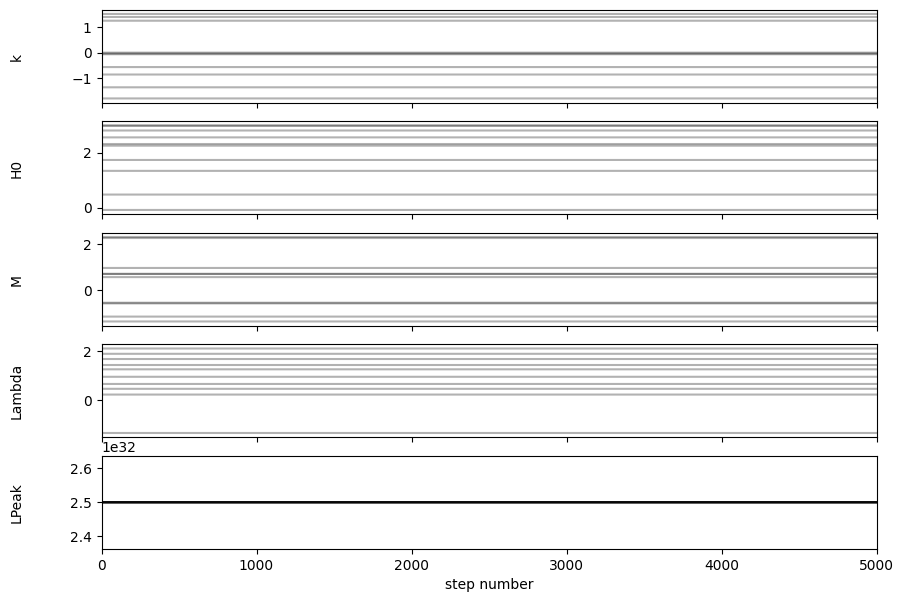

In [106]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["k", "H0", "M", "Lambda", "LPeak"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# Covariance plots

ValueError: It looks like the parameter(s) in column(s) 4 have no dynamic range. Please provide a `range` argument.

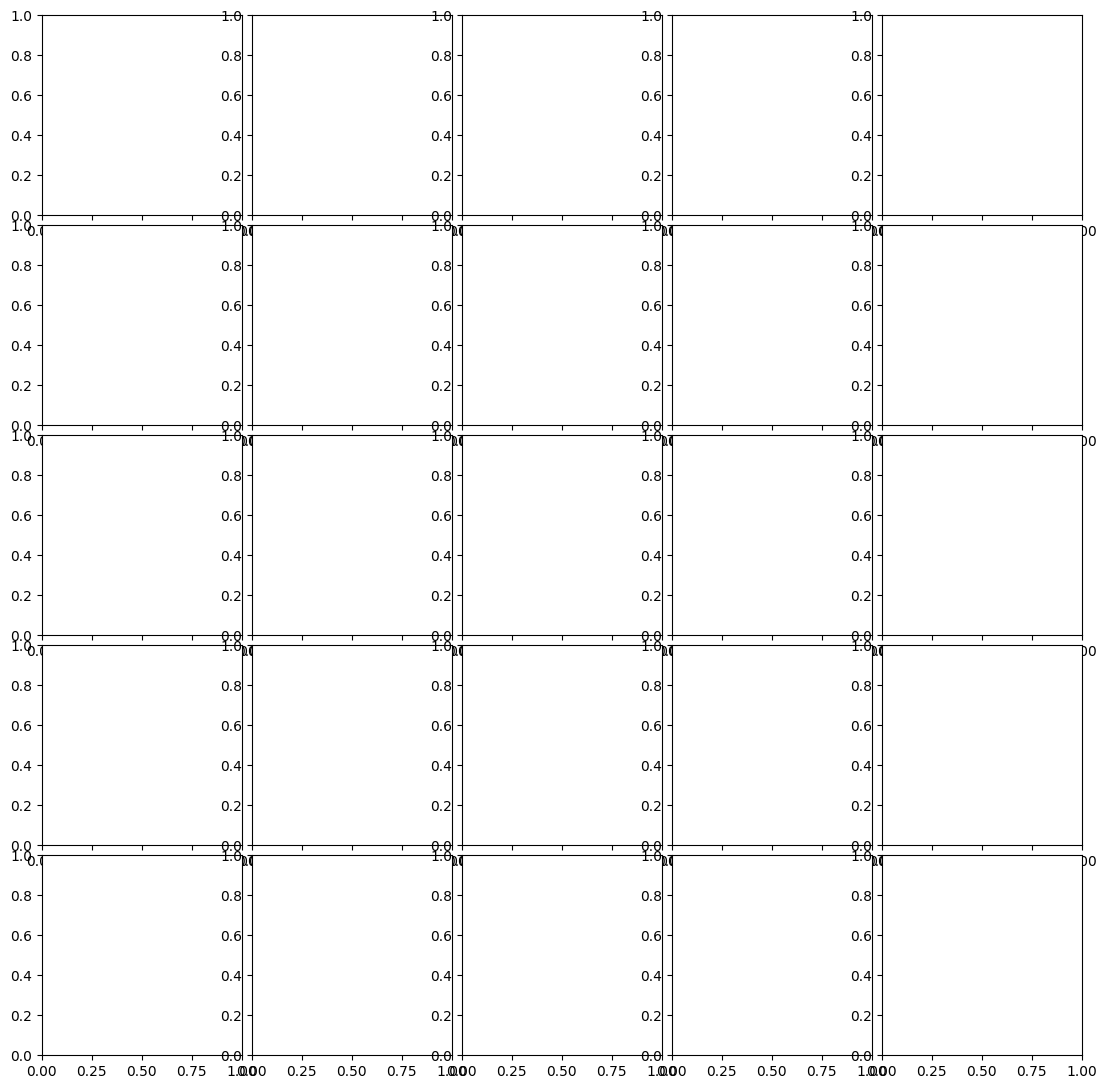

In [102]:

fig = corner.corner(
    flat_samples, labels = labels
)